Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: ES

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES

## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [28]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
import numpy as np
from numpy.random import normal
from collections import defaultdict
from copy import deepcopy
import matplotlib.pyplot as plt

## The *Nim* and *Nimply* classes

In [29]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [30]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

## Sample (and silly) startegies 

In [31]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = (
        random.randint(1, min(state.rows[row], state._k))
        if state._k
        else random.randint(1, state.rows[row])
    )
    return Nimply(row, num_objects)

In [32]:
# 2.1 agent in slides
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)
    ]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

In [33]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}

In [34]:
import numpy as np


# nim_sum: function often used in the mathematical analysis of the game to find winning strategies.
# https://www.archimedes-lab.org/How_to_Solve/Win_at_Nim.html#:~:text=To%20win%20at%20Nim%2Dgame,error%20in%20order%20to%20win.
def nim_sum(state: Nim) -> int:
    # tmp: for each row, transform the number of object in that row to its binary form (width 32 bit), binary as a tuple of bits
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int(
        "".join(str(_) for _ in xor), base=2
    )  # convert the string of bit in its integer form


def analize(raw: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = dict()
    for ply in (
        Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)
    ):
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp)
    return cooked


def optimal(state: Nim) -> Nimply:
    analysis = analize(state)
    logging.debug(f"analysis:\n{pformat(analysis)}")
    spicy_moves = [
        ply for ply, ns in analysis["possible_moves"].items() if ns != 0
    ]
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys())
    ply = random.choice(spicy_moves)
    # ply = max(spicy_moves, key=lambda m: m[1])
    return ply

## Evolution strategies

In [35]:
λ = 20
C = 2
C_sigma = 1
σ = 0.001

In [36]:
def check_valid_state(state: Nim, ply: Nimply) -> bool:
    # check 0 < num obj <= k
    if ply.num_objects <= 0 or ply.num_objects > state._k:
        return False
    return True

In [37]:
def fitness(poss_state: Nim) -> int:
    return nim_sum(poss_state)

### 2.2 Evolved agent

In [38]:
# tweak create 1 tweak only
def tweak(item: list, c_sigma) -> list:
    starting_move = item / 2  # for now we will take the real num.
    # offspring = round(normal(loc=starting_move, scale=C_sigma * starting_move))
    offspring = round(normal(loc=starting_move, scale=c_sigma * starting_move))
    # offsprings = round(normal(loc=starting_move, scale=C_sigma*starting_move, size=(C*item)))
    return offspring


def es(state: Nim, c_sigma=1) -> (Nimply, int):
    cooked = dict()
    created_off = 0
    # generate lambda new states, porportional to number of object in row
    for idx_row, row in enumerate(state.rows):
        # do C*row tweaks on this row
        n_tweaks = C * row
        created_off += n_tweaks
        for _ in range(n_tweaks):
            n_obj_offspring = tweak(row, c_sigma)
            tmp = deepcopy(state)
            ply = Nimply(idx_row, n_obj_offspring)
            try:
                tmp.nimming(
                    ply
                )  # nimming already checks if currecnt move (ply) and current state are valid
                if ply.num_objects > 0 and ply not in cooked.keys():
                    cooked[ply] = fitness(tmp)
            except:
                pass

    # select best choice in cooked[ply].
    if cooked:
        best_ply, best_fitness = max(cooked.items(), key=lambda t: t[1])
        # conto il numero di soluzioni "buone" trovate, se sono meno del 20% allora abbasso il sigma.
        # abbasso il sigma perchè alzandolo ci sono più probabilità di creare soluzioni fuori range.
        nim_diff_from_0 = 0
        for it in cooked.items():
            if it[1] != 0:
                nim_diff_from_0 += 1
        if nim_diff_from_0 / created_off <= 0.2:
            c_sigma /= 1.1
        else:
            c_sigma *= 1.1
    else:  # if no cooked move, then try again!
        # possible infinite loop
        # best_ply = es(state, c_sigma / 1.1)
        best_ply = pure_random(state)
        c_sigma /= 1.1

    return (best_ply, c_sigma)

2.2.1 Professor agent

In [39]:
def es2(state: Nim) -> Nimply:
    # test a bunch of random moves and take the best performing ones.
    first_moves = defaultdict(int)
    for _ in range(500):
        # let's make 500 games.
        nim = deepcopy(state)
        strategy = (pure_random, pure_random)
        # player is 0 because we are the one that moves.
        player = 0
        is_first = True
        while nim:
            ply = strategy[player](nim)
            if is_first:
                first_move = ply
                is_first = False
            nim.nimming(ply)
            player = 1 - player
        # add 1 to the first move value if we won with that move, 0 else
        first_moves[first_move] += 1 if player == 0 else 0

    best_move, n_wins = max(first_moves.items(), key=lambda i: i[1])
    return best_move

In [40]:
# '''# poss_state = state + a move

# ''' questo non serve '''
# width = 8 # using sigma=1 -> normal range approx between -4 and 4 ...
# sigma_row = 1/width # ... now in range approx of [-1, 1], using /width we can scale the gaussian after
# sigma_num_objects = 1/width

# def tweak(state: Nim) -> Nim:
#     new_state = copy(state)
#     new_state[index] = not new_state[index]
#     return new_state

# ''' questa non serve '''
# def tweak2(state, row, num_objects):
#     n_rows = len(state.rows)
#     row_es = -1
#     num_objects_es = -1

#     while row_es not in range(len(state.rows)): # generate until row_es is a valid one
#         row_es = round(row + np.random.normal(loc=0, scale=sigma_row*n_rows)) # n_rows is like a scaling factor for sigma

#     while (num_objects_es<0) or (num_objects_es>state._k): # generate until num_objects_es is a valid one
#         num_objects_es = round(num_objects + np.random.normal(loc=0, scale=sigma_row*state.rows[row_es]))

#     return row_es, num_objects_es'''

### (1, 1) - ES _(discarded)_


In [41]:
# '''# random moves + a (1,1) variation

# def es_1_1(state: Nim) -> Nimply:
#     # I tweak the state: if better fitness, return move, otherwise random move

#     '''Random move'''
#     row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
#     num_objects = random.randint(1, state.rows[row])
#     poss_state = Nimply(row, num_objects)

#     '''Gaussian evolution strategy''' ''' -> DO TWEAK ON STATE''' # TO DEBUG
#     # generate new row with an es
#     row_es, num_objects_es = tweak2(state, row, num_objects)
#     poss_state_es = Nimply(row_es, num_objects_es)

#     # check fitness
#     if fitness(poss_state_es) > fitness(poss_state):
#         return poss_state_es
#     else:
#         return poss_state'''

## Oversimplified match

In [50]:
logging.getLogger().setLevel(logging.INFO)

strategy = (es2, optimal)
GAMES = 500
wins_0 = 0 # wins of player 0
wins_1 = 0 # wins of player 1

# useful for plotting only
wins_over_games_list = [] # for each game [(win_0, win_1), (win_0, win_1), ...]

for _ in range(GAMES):
    nim = Nim(5)
    # logging.info(f"init : {nim}")
    player = 1
    c_sigma = 0.9
    while nim:
        # if player == 0:
        #     ply, c_sigma = strategy[player](nim, c_sigma)
        # else:
        ply = strategy[player](nim)
        # logging.info(f"ply: player {player} plays {ply}")
        nim.nimming(ply)
        # logging.info(f"status: {nim}")
        player = 1 - player
    # logging.info(f"status: Player {player} won!")
    if player == 0:
        wins_0 += 1
    else:
        wins_1 += 1
    # update stats for plot
    wins_over_games_list.append((wins_0, wins_1))

print(f"{int(wins_0/GAMES *100)}% of wins")

72% of wins


Text(0, 0.5, '% Wins')

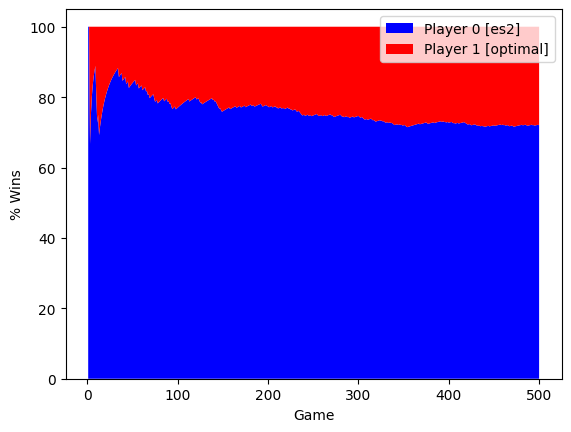

In [53]:
# PLOT
games_list = range(1, GAMES+1)
wins_0_over_games_list = np.array([x[0] for x in wins_over_games_list])/np.array(games_list)*100
wins_1_over_games_list = np.array([x[1] for x in wins_over_games_list])/np.array(games_list)*100

plt.stackplot(
    games_list, 
    wins_0_over_games_list, wins_1_over_games_list, 
    colors=['b', 'r'], 
    labels=[f'Player 0 [{strategy[0].__name__}]', f'Player 1 [{strategy[1].__name__}]']
    )
plt.legend()
plt.xlabel('Game')
plt.ylabel('% Wins')